# Fitness Classification Model

## Import dataset

In [91]:
import kagglehub
import os
import pandas as pd

path = kagglehub.dataset_download("muhammedderric/fitness-classification-dataset-synthetic")

print("Path to dataset files:", path)
print(os.listdir(path))

file_name = 'fitness_dataset.csv'
df = pd.read_csv(os.path.join(path, file_name))

print(df.head())


Path to dataset files: C:\Users\ASUS\.cache\kagglehub\datasets\muhammedderric\fitness-classification-dataset-synthetic\versions\1
['dataset-metadata.json', 'fitness_dataset.csv', 'README.md']
   age  height_cm  weight_kg  heart_rate  blood_pressure  sleep_hours  \
0   56        152         65        69.6           117.0          NaN   
1   69        186         95        60.8           114.8          7.5   
2   46        192        103        61.4           116.4          NaN   
3   32        189         83        60.2           130.1          7.0   
4   60        175         99        58.1           115.8          8.0   

   nutrition_quality  activity_index smokes gender  is_fit  
0               2.37            3.97     no      F       1  
1               8.77            3.19      0      F       1  
2               8.20            2.03      0      F       0  
3               6.18            3.68      0      M       1  
4               9.95            4.83    yes      F       1  


## Dataset structure

In [92]:
# Number of lines & cols
print(df.shape)

# Data types
print(df.info())

# Numerical vars stats
print(df.describe())

(2000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                2000 non-null   int64  
 1   height_cm          2000 non-null   int64  
 2   weight_kg          2000 non-null   int64  
 3   heart_rate         2000 non-null   float64
 4   blood_pressure     2000 non-null   float64
 5   sleep_hours        1840 non-null   float64
 6   nutrition_quality  2000 non-null   float64
 7   activity_index     2000 non-null   float64
 8   smokes             2000 non-null   object 
 9   gender             2000 non-null   object 
 10  is_fit             2000 non-null   int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 172.0+ KB
None
               age   height_cm    weight_kg   heart_rate  blood_pressure  \
count  2000.000000  2000.00000  2000.000000  2000.000000     2000.000000   
mean     49.114000   174.53300    83.

## Missing Values

In [93]:
print(df.isnull().sum())

age                    0
height_cm              0
weight_kg              0
heart_rate             0
blood_pressure         0
sleep_hours          160
nutrition_quality      0
activity_index         0
smokes                 0
gender                 0
is_fit                 0
dtype: int64


Class imbalance verification

In [94]:
print(df['is_fit'].value_counts())

is_fit
0    1201
1     799
Name: count, dtype: int64


## Label Encoding of categorical attributes (smokes and gender)

The "smokes" column, has ambiguous values. 
0 -> Means that the person does not smoke
1 -> Means that the person smokes
no -> Means that the person does not smoke
yes -> Means that the person smokes

So, I find necessary to apply a map function, converting zeros (0) and ones (1) into no or yes.

After that, the attribute is ready to Label Encode.

In [95]:
from sklearn.preprocessing import LabelEncoder

print(df['smokes'].value_counts())

mapping = {
    "0": 'no',
    "1": 'yes',
    'no': 'no',
    'yes': 'yes'
}

df['smokes'] = df['smokes'].astype(str).map(mapping)

le = LabelEncoder()
df['smokesEncoded'] = le.fit_transform(df['smokes'])
print(le.classes_)
print(df[['smokes', 'smokesEncoded']].head(10))

smokes
yes    711
0      581
no     518
1      190
Name: count, dtype: int64
['no' 'yes']
  smokes  smokesEncoded
0     no              0
1     no              0
2     no              0
3     no              0
4    yes              1
5    yes              1
6    yes              1
7     no              0
8     no              0
9     no              0


Now, I will apply the Label Encoding to the gender column.
Female -> 0
Male -> 1

In [96]:
print(df['gender'].value_counts())

le2 = LabelEncoder()
df['genderEncoded'] = le2.fit_transform(df['gender'])
print(le2.classes_)
print(df[['gender', 'genderEncoded']].head(10))

gender
F    1030
M     970
Name: count, dtype: int64
['F' 'M']
  gender  genderEncoded
0      F              0
1      F              0
2      F              0
3      M              1
4      F              0
5      M              1
6      F              0
7      M              1
8      F              0
9      F              0


## Delete pre-encoded columns (gender and smokes)

In [97]:
cols2del = ['gender', 'smokes']
df = df.drop(columns=cols2del)

## Handling Missing Values

So, the sleep_hours attribute has some rows with missing values.
I will make the decision of dropping those rows, because I want the prediction to be as accurate as possible and I don't want to induce a possible error!

In [98]:
df.dropna(axis=0, inplace=True)
print(df.shape)

(1840, 11)


## Data Plotting and Analysis

I will do boxplots in categories such as age, height, weight, heart rate, blood pressure and sleep hours, so I can see if there is any outlier.

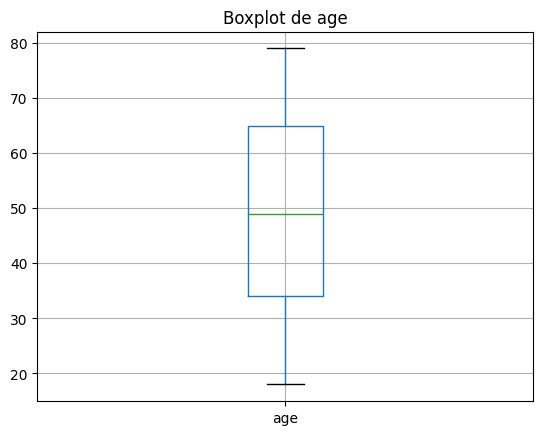

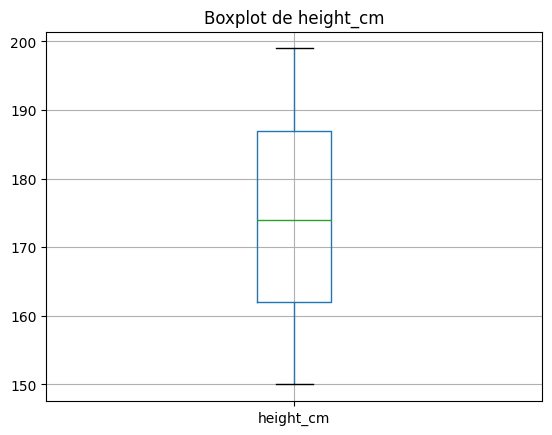

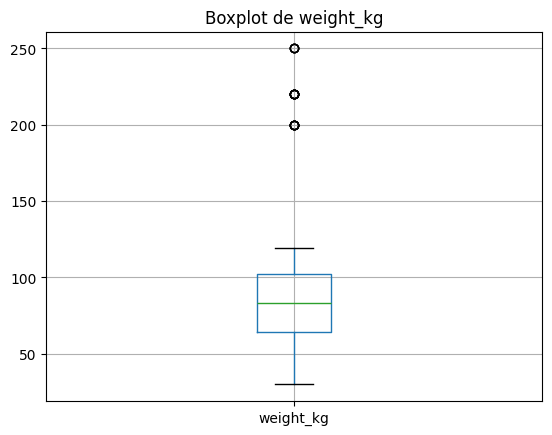

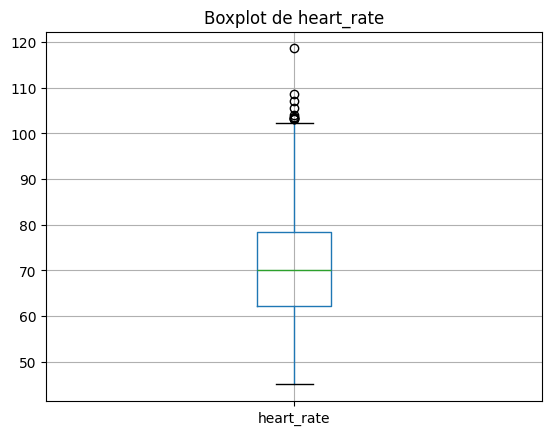

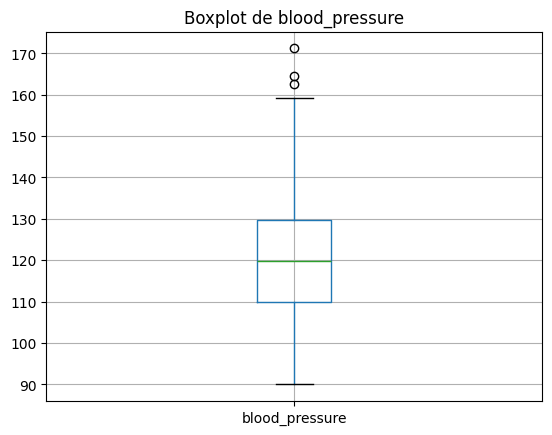

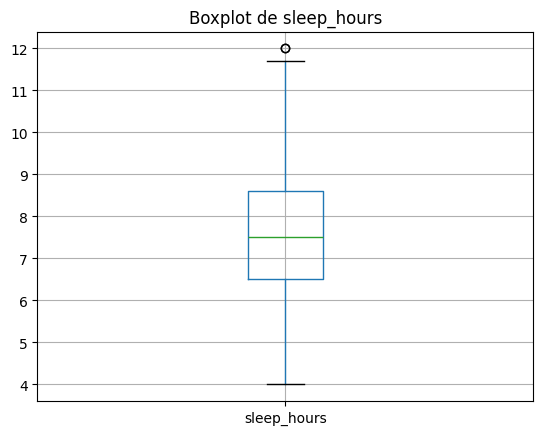

In [99]:
import matplotlib.pyplot as plt
categories_to_boxplot = ['age', 'height_cm', 'weight_kg', 'heart_rate', 'blood_pressure', 'sleep_hours']

for category in categories_to_boxplot:
    plt.figure()
    df.boxplot(column=category)
    plt.title(f'Boxplot de {category}')
    plt.show()

The author of the dataset revealed that the weight column had outliers, so, I will delete the ones detected in the boxplot.

Other than that, it is almost impossible to have a resting heart rate much higher than 100, so I will get rid of those rows too.

According to blood pressure health graphs, in the Systolic category (category revealed by the author of the dataset), normal values would be between less than 120 and 130 mm HG.

Values between 130 and 139 would be Stage 1 hypertension, over 140 would be Stage 2 hypertension and over 180 would cause an hypertension crisis, so, in this case, I will delete the row of the value higher than 160, because it would be almost impossible to have that value without serious concerns!

In the sleep_hours column, I will delete the every register higher than 10, only because I think that it is impossible to, consistently, sleep more than 10 hours straight.

### Weight outliers drop

In [100]:
df = df[df['weight_kg'] <= 200]
print(df.shape)

(1828, 11)


### Heart rate outliers drop

In [101]:
df = df[df['heart_rate'] <= 100]
print(df.shape)

(1811, 11)


### Blood pressure outliers drop

In [102]:
df = df[df["blood_pressure"] <= 160]
print(df.shape)

(1808, 11)


### Sleep hours outliers drop

In [103]:
df = df[df["sleep_hours"] < 11]
print(df.shape)

(1790, 11)


## Nutrition quality and Activity index values verification

The author says that in the nutrition quality column, values should be between 0 and 10, and that in the activity index column, between 1 and 5, so lets filter it like that!

In [104]:
print(f"Without filtering: {df.shape}")

df = df[(0 <= df['nutrition_quality']) & (df['nutrition_quality'] <= 10)]
print(f"Nutrition quality filtered: {df.shape}")

df = df[(0 <= df['activity_index']) & (df['activity_index'] <= 10)]
print(f"Activity index filtered: {df.shape}")

Without filtering: (1790, 11)
Nutrition quality filtered: (1790, 11)
Activity index filtered: (1790, 11)


As we can see, every value in those categories are between the correct interval!

## Correlation matrix

In [105]:
df.corr(method='pearson', min_periods=1).style.background_gradient(cmap='coolwarm')

,age,height_cm,weight_kg,heart_rate,blood_pressure,sleep_hours,nutrition_quality,activity_index,is_fit,smokesEncoded,genderEncoded
age,1.000000,0.017247,0.034676,-0.013348,-0.035269,-0.047307,0.010578,0.029321,-0.225957,-0.005101,-0.000570
height_cm,0.017247,1.000000,0.021210,-0.012824,-0.059405,-0.000469,0.023707,0.025397,0.062280,0.012773,-0.026940
weight_kg,0.034676,0.021210,1.000000,-0.020064,0.006434,-0.001396,-0.003022,-0.029206,-0.075702,0.046780,-0.019191
heart_rate,-0.013348,-0.012824,-0.020064,1.000000,0.038797,0.000365,0.009649,0.039626,0.042623,-0.004207,0.027608
blood_pressure,-0.035269,-0.059405,0.006434,0.038797,1.000000,-0.011157,-0.023479,-0.006395,-0.065821,-0.025241,-0.014457
sleep_hours,-0.047307,-0.000469,-0.001396,0.000365,-0.011157,1.000000,-0.031782,-0.029370,0.112868,-0.029884,0.032219
nutrition_quality,0.010578,0.023707,-0.003022,0.009649,-0.023479,-0.031782,1.000000,0.026765,0.256299,0.007809,0.011222
activity_index,0.029321,0.025397,-0.029206,0.039626,-0.006395,-0.029370,0.026765,1.000000,0.344990,-0.015474,0.033996
is_fit,-0.225957,0.062280,-0.075702,0.042623,-0.065821,0.112868,0.256299,0.344990,1.000000,-0.292212,0.150176
smokesEncoded,-0.005101,0.012773,0.046780,-0.004207,-0.025241,-0.029884,0.007809,-0.015474,-0.292212,1.000000,0.014612


After analyzing the correlation matrix, I came to the conclusion that the atributes that will certainly have more impact, either positive or negative, are nutrition quality (positive), activity index (positive) and smokes (negative).

I need to have age in attention too, but, in my opinion, age can't define directly if you are fit or not!

In [106]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1790 entries, 1 to 1999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1790 non-null   int64  
 1   height_cm          1790 non-null   int64  
 2   weight_kg          1790 non-null   int64  
 3   heart_rate         1790 non-null   float64
 4   blood_pressure     1790 non-null   float64
 5   sleep_hours        1790 non-null   float64
 6   nutrition_quality  1790 non-null   float64
 7   activity_index     1790 non-null   float64
 8   is_fit             1790 non-null   int64  
 9   smokesEncoded      1790 non-null   int32  
 10  genderEncoded      1790 non-null   int32  
dtypes: float64(5), int32(2), int64(4)
memory usage: 153.8 KB
None


## Removing duplicates

In [107]:
df = df.drop_duplicates()
print(df.shape)

(1790, 11)
